In [2]:
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import os
import numpy as np



This file is used to find the matching point for synchronization, before using it, you need to have the wav file extracted from the video. In addition, you need to extract all the frames from the video (including the calibration part), so that the frames for calibration can be selected.

In [3]:
# Get the spectogram data
name='0206002' # it refers to the path of a dataset (in which there are features generated from a video)
os.chdir("/home/gtx1080ti/Documents/hanyou2/0206/") # Home directory 
home="/home/gtx1080ti/Documents/hanyou2/0206/"+name+"/"
sample_rate, samples = wavfile.read('0206002.wav') # Can also put the wav file in the dataset directory
frequencies, times, spectogram = signal.spectrogram(samples, sample_rate) 


/home/gtx1080ti/.local/lib/python2.7/site-packages/scipy/signal/spectral.py:1785: UserWarning: nperseg = 256 is greater than input length  = 2, using nperseg = 2
  .format(nperseg, input_length))


In [4]:
spectogram.shape 

(16307828, 2, 1)

In [5]:
#remove redundant dimension
spectogram=np.einsum('abc->ba', spectogram)
spectogram=spectogram[0]
spectogram.shape

(16307828,)

In [6]:
#sampling from the data, cannot be too large but should be small enough to make them synchronize
#Current rate: 44100 ps
#So can choose 1 sample from every 105 samples, and choose 1/4 of the whole segment
#spectogram=spectogram[0:(len(spectogram)/4)]

In [7]:
samples=[]
for i in range(0, len(spectogram), 105):
    samples.append(spectogram[i])

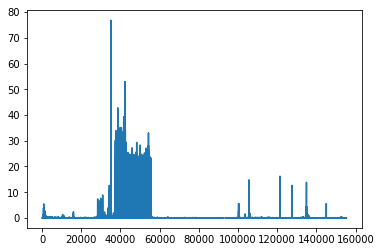

In [8]:
plt.plot(samples)
plt.show()

Then, we can observe the chart and zoom in iteratively to find the matching point

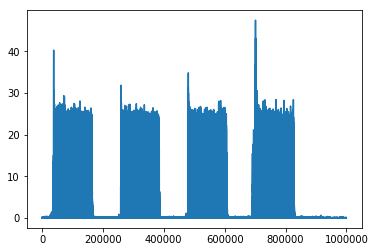

In [12]:
#This part has to be done manually
search=[]
for i in range(5000000,6000000,1):
    search.append(spectogram[i])
plt.plot(search)
plt.show()
#5826500

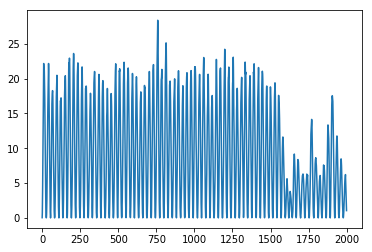

In [21]:
#This part has to be done manually
search=[]
for i in range(5825000,5827000,1):
    search.append(spectogram[i])
plt.plot(search)
plt.show()
#5826500

Then, we need to locate the timestamp of Tobii for this matching point, which can be found in the file that record the information. 15:11:18.067000

Afterwards, we can use it to calculate the time in seconds from the start of the video.

In [23]:
#Use 5826500 -- 15:11:18.067000
print(5826500.0/44100)
#15:11:18.067000-15:10:38.460=00:39:607
#By observation, set 250 as the starting point for calibration on phone
#1st (9-1)*1.6 + 1s = 13.8s
#2nd 4*1.6 + 1s = 21.2s 
#3rd 6*1.6 + 1s = 31.8s
#4th 6*1.6 + 1s = 42.4s
#5th 9*1.6 + 1s = 57.8s

132.120181406


Since the video for iTracker is started earlier than Tobii data (Cause we need to do the calibration for iTracker first), we need to find an index for iTracker data when Tobii start to record.

In [25]:
print 5826500-39.607*44100

4079831.3


In [26]:
print 4079831.3/44100*30
##the img index start from this number (30 fps)

2775.39544218


For selecting the calibration points, you need to observe the frames and find a suitable one (Cause the calibration points are generated by Tobii Machine, we have to do this mannually)

In [13]:
l_cali=[]
index=140
base="face"

p_interval=96
g_interval=61
for i in range(3):
    for j in range(3):
        l_cali.append(index)
        index+=p_interval
index+=g_interval

for i in range(2):
    for j in range(2):
        l_cali.append(index)
        index+=p_interval
index+=g_interval

for i in range(3):
    for j in range(2):
        l_cali.append(index)
        index+=p_interval
index+=g_interval

for i in range(2):
    for j in range(3):
        l_cali.append(index)
        index+=p_interval
index+=g_interval

for i in range(3):
    for j in range(3):
        l_cali.append(index)
        index+=p_interval
print l_cali

[140, 236, 332, 428, 524, 620, 716, 812, 908, 1065, 1161, 1257, 1353, 1510, 1606, 1702, 1798, 1894, 1990, 2147, 2243, 2339, 2435, 2531, 2627, 2784, 2880, 2976, 3072, 3168, 3264, 3360, 3456, 3552]


In [14]:
from shutil import copyfile
import shutil
if os.path.exists(home+'calibration'):
    shutil.rmtree(home+'calibration', ignore_errors=True)
os.makedirs(home+'calibration')
os.makedirs(home+'calibration/face')
os.makedirs(home+'calibration/eyeLeft')
os.makedirs(home+'calibration/eyeRight')
os.makedirs(home+'calibration/grid')
os.makedirs(home+'calibration/raw')


n=0
for i in l_cali:
    copyfile(home+'face/face'+str(i)+'.jpg',home+'calibration/face/face'+str(n)+'.jpg')
    copyfile(home+'eyeLeft/f'+str(i)+'eye2.jpg',home+'calibration/eyeLeft/f'+str(n)+'eye2.jpg')
    copyfile(home+'eyeRight/f'+str(i)+'eye1.jpg',home+'calibration/eyeRight/f'+str(n)+'eye1.jpg')
    copyfile(home+'raw/'+name+'-'+str('%05d' % (i,))+'.png',home+'calibration/raw/'+name+'-'+str(n)+'.png')
    copyfile(home+'grid/face_grid'+str(i),home+'calibration/grid/face_grid'+str(n))
    n+=1

We may plot the selected frames to see if they match the 34-points calibration pattern

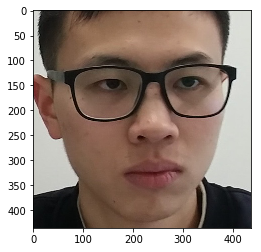

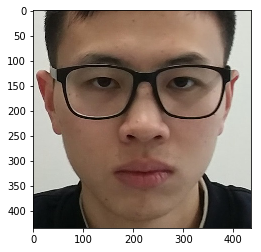

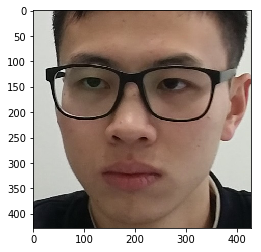

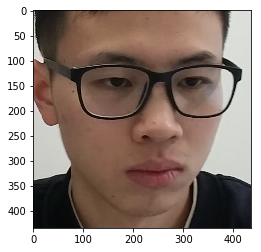

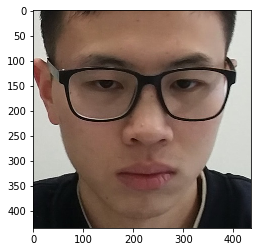

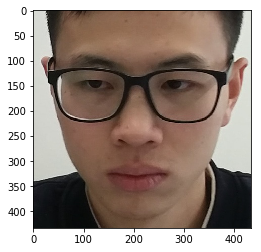

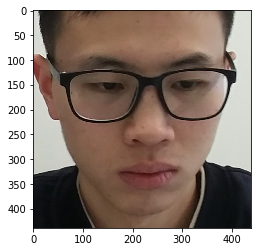

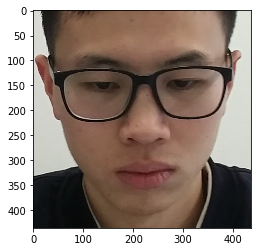

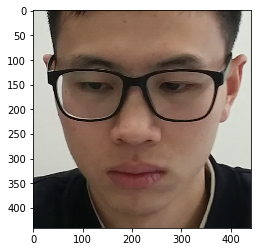

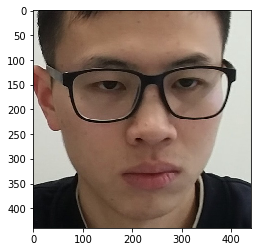

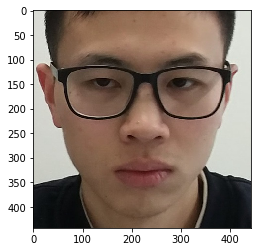

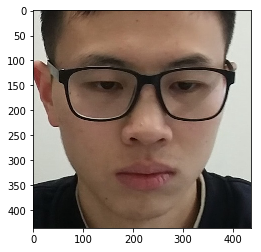

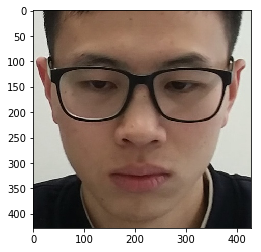

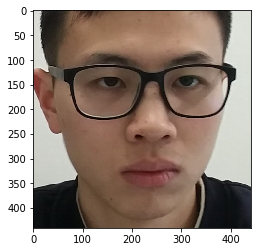

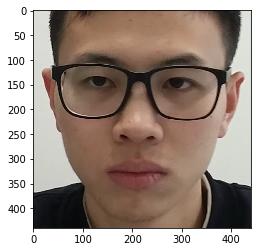

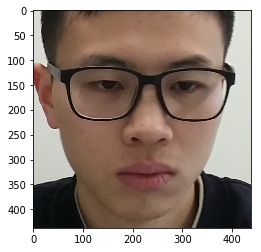

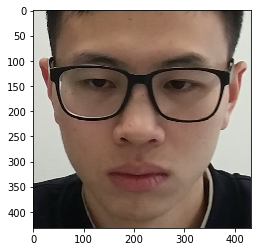

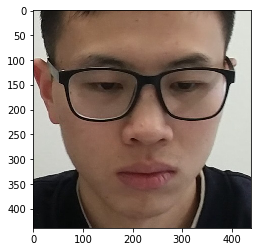

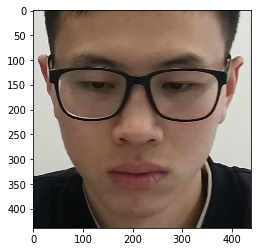

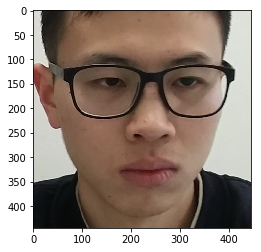

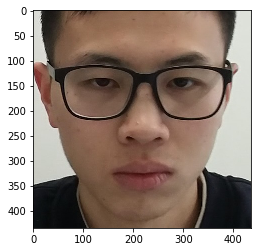

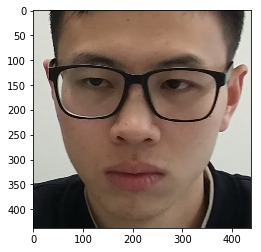

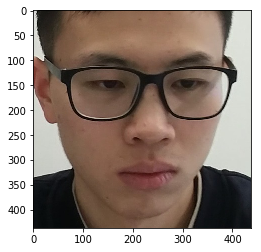

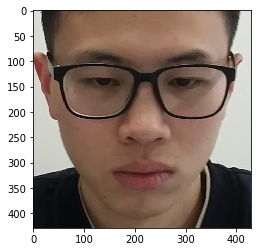

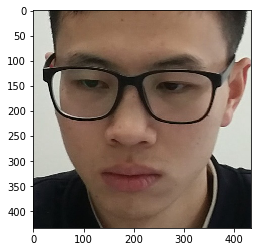

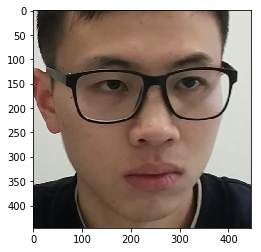

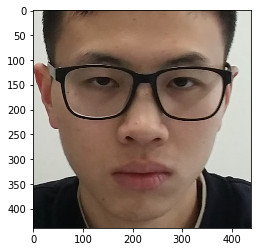

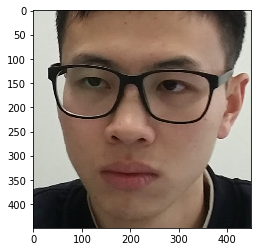

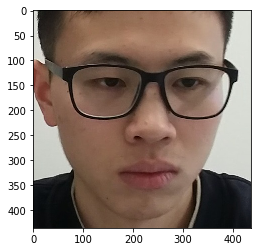

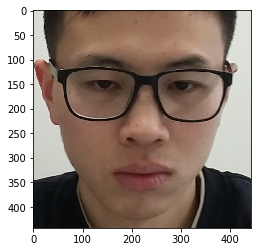

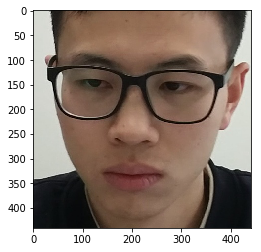

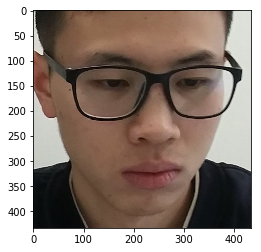

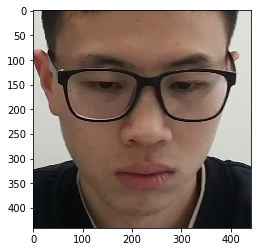

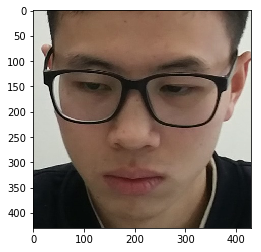

In [15]:

from PIL import Image

for i in l_cali:
    path=home+"face/face"+str(i)+".jpg"
    img=Image.open(path)
    plt.imshow(img)
    plt.show()